<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of the Multilevel dataset

Here we compute for each sample the coarse FEM solution that will then be given as imput to the NN of the fine level

#### Import libraries

In [2]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
from itertools import product
import timeit
import pandas as pd 
from keras.optimizers import Adam,Nadam,Adamax
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from sklearn.utils import extmath
from fenics import *

import sys
sys.path.append('./solver')
from model import *
#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

2024-07-12 17:29:16.387452: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import the dataset 

In [5]:
X_train = np.loadtxt('./data/X_train_64000.csv', delimiter = ',')
y_train = np.loadtxt('./data/y_train_64000.csv', delimiter = ',')

X_test = np.loadtxt('./data/X_test_64000.csv', delimiter = ',')
y_test = np.loadtxt('./data/y_test_64000.csv',delimiter = ',')

In [34]:
# Set the resolution of the model and the random field parameters.
resolution_fine = (50, 50)
resolution_coarse = (25, 25)
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl = 64

# set dataponts
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
#x_data = y_data = np.linspace(0,1,26)
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data)*len(y_data)

# Set up the model(s)
solver_c = Model(resolution_coarse, field_mean, field_stdev, mkl, lamb_cov)
solver_f = Model(resolution_fine, field_mean, field_stdev, mkl, lamb_cov)


def solver_fine(x):
    solver_f.solve(x)
    return solver_f.get_data(datapoints)


def solver_coarse(x):
    solver_c.solve(x)
    return solver_c.get_data(datapoints)

Compare the time for each solver

In [4]:
start_0 = timeit.default_timer() 
coarse_predictions = [solver_coarse(X_train[i,:]) for i in range(10000)]
end_0 = timeit.default_timer()
 
start_1 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(10000)]
end_1= timeit.default_timer()

print('Time Coarse', (end_0-start_0)/10000)
print('Time Fine', (end_1-start_1)/10000)
print('\nThe speedup coefficient is:', (end_1 - start_1)/(end_0-start_0))

Time Coarse 0.005402068479099944
Time Fine 0.012302980774999923

The speedup coefficient is: 2.277457389257265


# Time comparison with high fidelity NN

Load medium level 

In [4]:
model_m = Sequential()

model_m.add(Dense(256, input_shape=(89,), activation='gelu'))
model_m.add(Dense(256, activation='gelu'))
model_m.add(Dense(128, activation='gelu'))
model_m.add(Dense(25, activation='exponential'))

model = load_model('./models/model_HF_25_2.keras')

def model_mf(x):
    x_c = np.hstack([x,solver_coarse(x)]).reshape((1,89))
    return model(x_c)


/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Load model low fidelity

In [8]:
model_l = Sequential()
model_l.add(Dense(64, input_shape=(64,), activation='sigmoid'))
model_l.add(Dense(128, activation='sigmoid'))
model_l.add(Dense(25, activation='exponential'))
model_l = load_model('./models/model_NN_64_sigmoid3.keras')

def model_lf (input):
    return np.array(model_l(input.reshape((1,64)))).reshape(25)

Compare different speed 

In [9]:
start_0 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(10000)]
end_0= timeit.default_timer()

start_1 = timeit.default_timer() 
coarse_predictions = [model_mf(X_train[i,:]) for i in range(10000)]
end_1 = timeit.default_timer()
 
start_2 = timeit.default_timer() 
fine_predictions = [model_lf(X_train[i,:]) for i in range(10000)]
end_2= timeit.default_timer()


print('Time High Fidelity', (end_0-start_0)/10000)
print('Time Medium Fidelity', (end_1-start_1)/10000)
print('Time Low Fidelity', (end_1-start_1)/10000)
print('\nThe speedup coefficient High / Medium is:', (end_0 - start_0)/(end_1-start_1))
print('\nThe speedup coefficient High / Low is:', (end_0 - start_0)/(end_2-start_2))
print('\nThe speedup coefficient Medium / Low is:', (end_1 - start_1)/(end_2-start_2))

Time High Fidelity 0.012173732491700139
Time Medium Fidelity 0.00817087467500005
Time Low Fidelity 0.00817087467500005

The speedup coefficient High / Medium is: 1.4898934295183108

The speedup coefficient High / Low is: 7.475379334120851

The speedup coefficient Medium / Low is: 5.017391973154533


# Evaluation of the performance of the POD-ML Model

In [39]:
resolution_coarse = (25, 25)
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl = 64
# set dataponts
x_data = y_data = np.linspace(0,1,26)
datapoints = np.array(list(product(x_data, y_data)))
n_datapoints = len(x_data)*len(y_data)
# Set up the model(s)
solver_c = Model(resolution_coarse, field_mean, field_stdev, mkl, lamb_cov)
b = np.loadtxt("./data/POD_basis.csv", delimiter=',')[:,0:10]


In [40]:
model_pod = Sequential()

# Add layers to the model
model_pod.add(Dense(256, input_shape=(74,), activation='gelu'))
model_pod.add(Dense(256, activation='gelu'))
model_pod.add(Dense(256, activation='gelu'))
model_pod.add(Dense(25, activation='linear'))

model_pod = load_model('./models/model_HF_POD_2.keras')


/Users/lucacaroselli/miniconda3/envs/fenics/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
def model_hf_pod(x):
    solver_c.solve(x)
    pod_coeff = solver_c.get_data(datapoints) @ b
    x_new = np.hstack((x,pod_coeff))
    return np.array(model_pod(x_new.reshape((1,74)))).reshape(25)


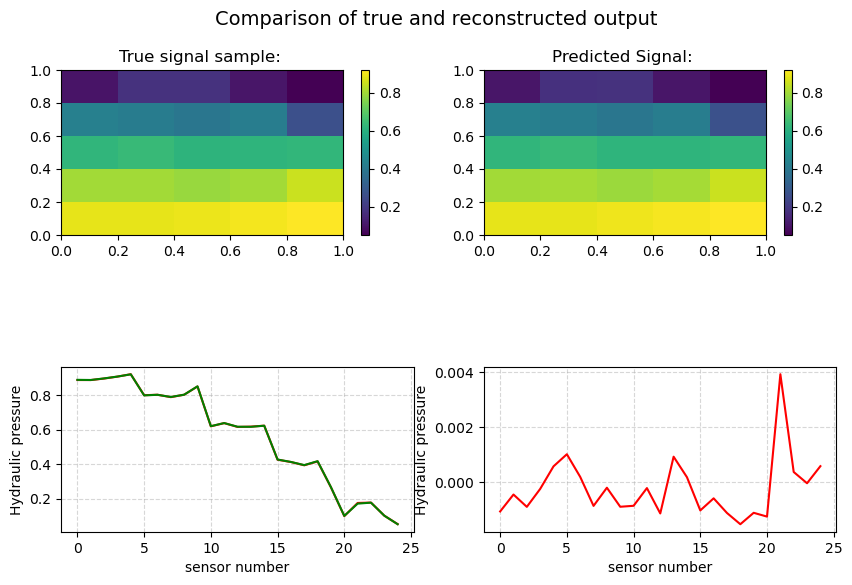

In [42]:
sample = 150

y_true = y_test[sample]
y_pred = model_hf_pod(X_test[sample,:])

# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

fig = plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.8)
title = 'Comparison of true and reconstructed output'
fig.suptitle(title, fontsize=14)
    
ax = fig.add_subplot(2,2, 1)
pcm = plt.pcolormesh(X, Y, y_true.reshape((5, 5)))
ax.title.set_text('True signal sample: ')
plt.colorbar(pcm, ax=ax)
    
ax = fig.add_subplot(2,2, 2)
pcm = plt.pcolormesh(X, Y, y_pred.reshape((5, 5)) )
ax.title.set_text('Predicted Signal: ')
plt.colorbar(pcm, ax=ax)


ax = fig.add_subplot(2,2, 3)
plt.plot(range(25), y_true, c='red', label='Real', linewidth=1.5)
plt.plot(range(25), y_pred, 'green', label='Pred', linewidth=1.5)
plt.xlabel('sensor number')
plt.ylabel('Hydraulic pressure')
plt.grid(True, linestyle='--', alpha=0.5)

ax = fig.add_subplot(2,2, 4)
plt.plot(range(25), y_true-y_pred, c='red', label='obs-reconst', linewidth=1.5)
plt.xlabel('sensor number')
plt.ylabel('Hydraulic pressure')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


Compare the speed 

In [46]:
start_0 = timeit.default_timer() 
fine_predictions = [solver_fine(X_train[i,:]) for i in range(10000)]
end_0= timeit.default_timer()

start_1 = timeit.default_timer() 
coarse_predictions = [model_hf_pod(X_train[i,:]) for i in range(10000)]
end_1 = timeit.default_timer()

print('Time High Fidelity', (end_0-start_0)/10000)
print('Time Low Fidelity', (end_1-start_1)/10000)
print('\nThe speedup coefficient High / Low is:', (end_0 - start_0)/(end_1-start_1))

Time High Fidelity 0.018717722245899494
Time Low Fidelity 0.012871506916702493

The speedup coefficient High / Low is: 1.454198204377357
